In [7]:
import torch
from scipy.io import loadmat
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch import nn
from tkinter import filedialog
import tkinter as tk
from neurorobotics_dl.utils import MyDataset,summary,get_class
from neurorobotics_dl.trainer import MyTrainer

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt

import os
from neurorobotics_dl.processing import read_gdf, filter_data
from joblib import dump,load

class Event():
    START = 1
    CONT_FEEDBACK = 781
    FIXATION = 786
    HIT = 897
    MISS = 898
    TIMEOUT = 899
    REST = 700
    LEFT_ALIGNMENT_STEP = 701
    LEFT_STEP = 702
    RIGHT_ALIGNMENT_STEP = 703
    RIGHT_STEP = 704
    MOVEMENT_START = 333
    BOTH_HANDS = 773
    BOTH_FEET = 771
    REST = 783

    OFFSET = 0X8000

def select_files(initialdir='./recordings'):
    root = tk.Tk()
    root.withdraw()
    filenames = filedialog.askopenfilenames(initialdir=initialdir,defaultextension='gdf')
    return filenames

def create_windows(eeg, events, window_size, window_shift,start_after = 0,end_before = 0):
    windows,winlabels = [],[]
    for _,row in tqdm(events.iterrows(),leave=False,total=len(events)):
        start,stop = row['POS'] + start_after, row['POS']+row['DUR'] - end_before
        if type(window_shift) == dict:
            shift = window_shift[row['label']]
        else: 
            shift = window_shift
        while start+window_size < stop:
            winlabels.append(row['label'])
            windows.append(eeg[start:start+window_size])
            start+=shift
    windows = np.stack(windows)
    windows = torch.from_numpy(windows).float().unsqueeze(1).permute(0,1,3,2)  
    winlabels = torch.tensor(winlabels).long()

    return windows,winlabels

def predict_all(model,dataloader,device):
    model.eval()

    model.to(device)
    logits = []
    labels = []
    with torch.no_grad():
            
        for x,y in tqdm(dataloader):
            x = x.to(device)
            out = model(x)
            logits.append(out)
            labels.append(y)
        logits = torch.vstack(logits).cpu().numpy()
        labels = torch.cat(labels).cpu().numpy()
        return logits,labels

def show_results(model,dataloader,device,criterion=torch.nn.CrossEntropyLoss(),ax=None):
    logits,labels = predict_all(model,dataloader,device)
    acc = (logits.argmax(axis=1) == labels).mean()
    loss = criterion(torch.from_numpy(logits),torch.from_numpy(labels)).item()
    f1 = f1_score(labels,logits.argmax(axis=1),average='macro')
    print("F1: {:.2f}% | Acc: {:.2f}% | Loss: {}".format(f1*100,acc*100,loss))
    cm = confusion_matrix(labels,logits.argmax(axis=1))
    ConfusionMatrixDisplay(cm).plot(ax=ax)


def preprocess(filenames,save_path=None):
    eegs = []
    all_events = []
    last_eeg_len = 0
    for fileno, filename in enumerate(filenames):        
        tqdm.write(str(fileno)+ " - "+ filename.split('/')[-2]+" - "+filename.split('/')[-1], end = ' - ')
        subj =  filename.split('/')[-1].split('.')[0]

        eeg,h = read_gdf(filename,drop_chans=['sens1','Status','trigger:1'])
        fs = h['SampleRate'] 
        events = h['EVENT']

        eeg = filter_data(eeg, fs,fc_bp=[2,40])
        events['POS'] += last_eeg_len
        events['FILENO'] = fileno
        events['FILENAME'] = filename.split('/')[-1]
        events['SUBJ'] = subj
        
        eegs.append(eeg)
        all_events.append(events)
        last_eeg_len += len(eeg)

    eegs = np.concatenate(eegs)
    all_events = pd.concat(all_events)

    preprocessed = {'data':eegs,
                    'events':all_events,
                    'info': h['ChannelNames']
                }
    
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
        dump(preprocessed,os.path.join(save_path,f'preprocessed.pkl'))
    
    
    return preprocessed

In [9]:
MANUAL_PICK = False
SAVE_PATH='../cache'

if MANUAL_PICK:
    filenames = select_files('../recordings/train')
    if not filenames:
        print('No files selected! Nothing to preprocess!')
    else: dataset = preprocess(filenames,SAVE_PATH)
else:
    dataset = load(os.path.join(SAVE_PATH,f"preprocessed.pkl"))

In [10]:
out_path = "generic_wheel"

train_batch_size = 32
eval_batch_size = 256
device = 'cuda'

label_map = { # PUT ALL THE CUE CODES HERE OTHERWISE IT FAILS, -1 TO IGNORE  
  771: -1, 
  773: -1, 
  769: 0, 
  770: 1, 
  783: -1
  }
num_classes = np.unique(list(label_map.values())).shape[0]
window_size = 512
window_shift = {
    0:32,
    1:32,
  }
start_after = 256
end_before = 256

eeg = dataset['data']
events = dataset['events']
num_channels = eeg.shape[1]

labels = events['TYP'].map(label_map).dropna().values.astype(int)


cf_events = events[events['TYP'] == Event.CONT_FEEDBACK].copy()
cf_events['label'] = labels
cf_events = cf_events[cf_events['label'] >= 0].reset_index(drop=True)
cf_events

,TYP,POS,DUR,FILENO,FILENAME,SUBJ,label
0,781,4154,2135,0,i2.20260129.140929.calibration.mi_bhbf.gdf,i2,0
1,781,8900,2130,0,i2.20260129.140929.calibration.mi_bhbf.gdf,i2,1
2,781,13641,2284,0,i2.20260129.140929.calibration.mi_bhbf.gdf,i2,1
3,781,18537,2421,0,i2.20260129.140929.calibration.mi_bhbf.gdf,i2,1
4,781,23570,2176,0,i2.20260129.140929.calibration.mi_bhbf.gdf,i2,0
...,...,...,...,...,...,...,...
95,781,547297,1260,4,i2.20260129.144046.evaluation.mi_bhbf.buffer.gdf,i2,1
96,781,551168,3246,4,i2.20260129.144046.evaluation.mi_bhbf.buffer.gdf,i2,1
97,781,557026,937,4,i2.20260129.144046.evaluation.mi_bhbf.buffer.gdf,i2,0
98,781,560574,3886,4,i2.20260129.144046.evaluation.mi_bhbf.buffer.gdf,i2,1


In [11]:
## Choose one between 70-15-15 split or manual selecting files. comment the other

## 70-15-15 split
#train_files = range(len(filenames))
#train_events = trial_events[trial_events['FILENO'].isin(train_files)]
#val_events = train_events[int(len(train_events)*0.7):int(len(train_events)*0.85)]
#test_events = train_events[int(len(train_events)*0.85):]
#train_events = train_events[:int(len(train_events)*0.7)]

# ## Separate sessions
train_files = [0,1,2]
val_files =[3]
test_files = [4]
train_events = cf_events[cf_events['FILENO'].isin(train_files)]
val_events = cf_events[cf_events['FILENO'].isin(val_files)]
test_events = cf_events[cf_events['FILENO'].isin(test_files)]


#Create datasets and dataloaders
train_w,train_l = create_windows(eeg, train_events, window_size, window_shift,start_after,end_before)
val_w,val_l = create_windows(eeg, val_events, window_size, window_shift,start_after,end_before)
test_w,test_l = create_windows(eeg, test_events, window_size, window_shift,start_after,end_before)

# Apply standardization
mu,sigma = train_w.mean(axis = (0,1,3),keepdims=True),train_w.std(axis = (0,1,3),keepdims=True)
train_w = (train_w - mu) / sigma
val_w = (val_w - mu) / sigma
test_w = (test_w - mu) / sigma

if not os.path.exists(out_path):
    os.makedirs(out_path)
np.savez(os.path.join(out_path,"mean_std.npz"),mu=mu,sigma=sigma)

for e in (torch.unique(train_l,return_counts=True),
torch.unique(val_l,return_counts=True),
torch.unique(test_l,return_counts=True)): print(e)

train_loader = DataLoader(MyDataset(train_w,train_l), batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(MyDataset(val_w,val_l), batch_size=eval_batch_size, shuffle=False)
test_loader = DataLoader(MyDataset(test_w,test_l), batch_size=eval_batch_size, shuffle=False)

(tensor([0, 1]), tensor([1329, 1351]))
(tensor([0, 1]), tensor([149, 636]))
(tensor([0, 1]), tensor([117, 650]))


In [12]:
# # EEGNET
model_config = {
  'classname': 'neurorobotics_dl.models.EEGNet',
  'options': {
    'nb_classes': num_classes,
    'Chans': num_channels,
    'Samples': window_size,
    'dropoutRate': 0.5,
    'kernLength': window_size//2,
    'F1': 8,
    'D': 2,
    'F2': 16
  }
}


# # TGCN
# model_config = {
#   'classname': 'neurorobotics_dl.models.GCN_GRU_sequence_fxdD',
#   'options': { 'num_channels': 32,
#                'gcn_input_dim' : 8,
#                'num_classes' : num_classes,
#                'gcn_output_dim' : 16,
#                'gru_hidden_units' : 16,
#                'gcn_dropout' : 0.3,
#                'gru_dropout' : 0.5
#   }
# }

# # GRU
# model_config = {
#   'classname': 'models.RNN',
#   'options': { 'input_size': 32,
#                'num_classes' : num_classes,
#                'hidden_size' : 128,
#                'num_layers' : 1,
#   }
# }

# PhiNet
model_config = {
  'classname': ' micromind.networks.PhiNet',
  'options': {'input_shape':(1, num_channels, window_size),
               'num_classes':num_classes,
               'num_layers' : 6,
               'alpha':0.5,
               'beta':2,
               't_zero':1.5,
               'include_top':True
}
}

# # AttentionNet
# model_config = {
#   'classname': 'models.AttentionNet',
#   'options': { 'num_channels':32,
#                'num_classes':num_classes,
#                'num_heads':1,
#                'hidden_size':128,
#                'enforce_simmetry':True
#   }
# }

# # EEGTransformer
# model_config = {
#   'classname': 'neurorobotics_dl.models.EEGTransformer',
#   'options': { 'd_model' : 32, 
#               'embedding_dim' : 2, 
#               'encoder_layer_args':{'nhead':4,'batch_first':True},
#               'encoder_args':{'num_layers':2},
#   }
# }


model = get_class(model_config['classname'])(**model_config['options']).to(device)

summary(model)
class WeightClipper(object):
    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'Wa'):
            module.Wa.data.clamp_(0,1)

Model Parameters:
+-------------------------------------+--------+-----------------------------+-----------+
|                Layer                | Params |            Shape            | Trainable |
+-------------------------------------+--------+-----------------------------+-----------+
|      _layers.1._layers.0.weight     |   9    |   torch.Size([1, 1, 3, 3])  |    True   |
|      _layers.1._layers.1.weight     |   24   |  torch.Size([24, 1, 1, 1])  |    True   |
|      _layers.1._layers.2.weight     |   24   |       torch.Size([24])      |    True   |
|       _layers.1._layers.2.bias      |   24   |       torch.Size([24])      |    True   |
|      _layers.2._layers.1.weight     |  216   |  torch.Size([24, 1, 3, 3])  |    True   |
|      _layers.2._layers.2.weight     |   24   |       torch.Size([24])      |    True   |
|       _layers.2._layers.2.bias      |   24   |       torch.Size([24])      |    True   |
|      _layers.2._layers.4.weight     |  288   |  torch.Size([12, 24, 1,

In [13]:
from torch.optim import Adam,AdamW,SGD
model = get_class(model_config['classname'])(**model_config['options']).to(device)


optimizer = Adam(model.parameters(),lr = 0.0001,weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,1,0.1,100)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
"""   TRAIN   """
trainer = MyTrainer(model,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    es_patience=0,
                    es_min_delta=0,
                    # contraints=WeightClipper()
                    )

trainer.train( 60,
                criterion,
                train_loader,
                val_loader,
                logger_name=os.path.join(out_path,"training.log"),
                device = device,
                path=out_path,
                )

  2%|▏         | 1/60 [00:03<03:04,  3.12s/it]

Epoch 1/60	 Train Loss: 1.1288181497089897, Train Acc: 0.2794776119402985, Val Loss: 1.3030687720912277, Val Acc: 0.09299363076307211
New best loss achieved: 1.3030687720912277


  3%|▎         | 2/60 [00:05<02:33,  2.64s/it]

Epoch 2/60	 Train Loss: 1.078469601495942, Train Acc: 0.4697761197588337, Val Loss: 1.3834151773695733, Val Acc: 0.21910828027375945


  5%|▌         | 3/60 [00:07<02:23,  2.52s/it]

Epoch 3/60	 Train Loss: 1.0203960443610576, Train Acc: 0.5891791044776119, Val Loss: 1.730405644398586, Val Acc: 0.25095541401748445


  7%|▋         | 4/60 [00:10<02:15,  2.43s/it]

Epoch 4/60	 Train Loss: 0.9241512919539836, Train Acc: 0.6720149257289829, Val Loss: 1.5480319640439026, Val Acc: 0.41656051008564654


  8%|▊         | 5/60 [00:12<02:11,  2.39s/it]

Epoch 5/60	 Train Loss: 0.8257026894768672, Train Acc: 0.7347014928931621, Val Loss: 1.461085211851035, Val Acc: 0.4802547771459932


 10%|█         | 6/60 [00:14<02:06,  2.34s/it]

Epoch 6/60	 Train Loss: 0.7009012001663891, Train Acc: 0.7611940298507462, Val Loss: 1.768017564457693, Val Acc: 0.40382165605095544


 12%|█▏        | 7/60 [00:17<02:05,  2.36s/it]

Epoch 7/60	 Train Loss: 0.6073742108558541, Train Acc: 0.8037313436394307, Val Loss: 1.4940709592430454, Val Acc: 0.7057324843042215


 13%|█▎        | 8/60 [00:19<02:01,  2.34s/it]

Epoch 8/60	 Train Loss: 0.5090430802373743, Train Acc: 0.8302238809528636, Val Loss: 1.5035150240181359, Val Acc: 0.6815286625722411


 15%|█▌        | 9/60 [00:21<01:59,  2.34s/it]

Epoch 9/60	 Train Loss: 0.46297795986061663, Train Acc: 0.8488805971928497, Val Loss: 1.4004717502624366, Val Acc: 0.6433121021386164


 17%|█▋        | 10/60 [00:24<01:57,  2.34s/it]

Epoch 10/60	 Train Loss: 0.41138942891092445, Train Acc: 0.863059701848386, Val Loss: 1.5665448654609122, Val Acc: 0.6038216562028144


 18%|█▊        | 11/60 [00:26<01:53,  2.31s/it]

Epoch 11/60	 Train Loss: 0.38253890498360593, Train Acc: 0.8716417914006247, Val Loss: 1.5478838220333597, Val Acc: 0.5261146496815287


 20%|██        | 12/60 [00:28<01:51,  2.33s/it]

Epoch 12/60	 Train Loss: 0.32436086086194904, Train Acc: 0.8992537313432836, Val Loss: 0.9214275624342025, Val Acc: 0.7770700638461265
New best loss achieved: 0.9214275624342025


 22%|██▏       | 13/60 [00:30<01:49,  2.32s/it]

Epoch 13/60	 Train Loss: 0.295631879034327, Train Acc: 0.9111940298507463, Val Loss: 1.3288843342073404, Val Acc: 0.686624203821656


 23%|██▎       | 14/60 [00:33<01:46,  2.32s/it]

Epoch 14/60	 Train Loss: 0.2664896331171491, Train Acc: 0.9175373134328358, Val Loss: 1.0027391296283454, Val Acc: 0.749044586290979


 25%|██▌       | 15/60 [00:35<01:44,  2.33s/it]

Epoch 15/60	 Train Loss: 0.2557628357588355, Train Acc: 0.9205223884155501, Val Loss: 1.3186736111997799, Val Acc: 0.7057324840764331


 27%|██▋       | 16/60 [00:37<01:42,  2.32s/it]

Epoch 16/60	 Train Loss: 0.2299238063506226, Train Acc: 0.9291044777898646, Val Loss: 1.1923024190079634, Val Acc: 0.6828025477707006


 28%|██▊       | 17/60 [00:40<01:40,  2.35s/it]

Epoch 17/60	 Train Loss: 0.22609905831849397, Train Acc: 0.9179104481170427, Val Loss: 1.3077641891635907, Val Acc: 0.6331210191842097


 30%|███       | 18/60 [00:42<01:38,  2.34s/it]

Epoch 18/60	 Train Loss: 0.21793155407727655, Train Acc: 0.9283582089552239, Val Loss: 1.1185320229856832, Val Acc: 0.7019108281014071


 32%|███▏      | 19/60 [00:45<01:36,  2.35s/it]

Epoch 19/60	 Train Loss: 0.19986047055294265, Train Acc: 0.9335820899080874, Val Loss: 1.049583463835868, Val Acc: 0.7210191084321137


 33%|███▎      | 20/60 [00:47<01:33,  2.35s/it]

Epoch 20/60	 Train Loss: 0.18594143288349038, Train Acc: 0.9361940298507463, Val Loss: 1.277395434734548, Val Acc: 0.7159235668789808


 35%|███▌      | 21/60 [00:49<01:32,  2.36s/it]

Epoch 21/60	 Train Loss: 0.19443958390559724, Train Acc: 0.9361940298507463, Val Loss: 1.0396626821369122, Val Acc: 0.7426751595393867


 37%|███▋      | 22/60 [00:52<01:29,  2.35s/it]

Epoch 22/60	 Train Loss: 0.17721726347261402, Train Acc: 0.9361940298507463, Val Loss: 1.5138093253419658, Val Acc: 0.5694267515923567


 38%|███▊      | 23/60 [00:54<01:26,  2.33s/it]

Epoch 23/60	 Train Loss: 0.16193337845268535, Train Acc: 0.9481343287140576, Val Loss: 1.271823390691903, Val Acc: 0.6624203821656051


 40%|████      | 24/60 [00:56<01:23,  2.32s/it]

Epoch 24/60	 Train Loss: 0.18199805630676782, Train Acc: 0.9343283582089552, Val Loss: 1.4710090869741075, Val Acc: 0.5796178344708339


 42%|████▏     | 25/60 [00:58<01:21,  2.32s/it]

Epoch 25/60	 Train Loss: 0.15031714237003185, Train Acc: 0.951865671641791, Val Loss: 0.8536331211685375, Val Acc: 0.7974522296790105
New best loss achieved: 0.8536331211685375


 43%|████▎     | 26/60 [01:01<01:18,  2.32s/it]

Epoch 26/60	 Train Loss: 0.16388012791302667, Train Acc: 0.9447761194029851, Val Loss: 1.389791518487748, Val Acc: 0.6458598726114649


 45%|████▌     | 27/60 [01:03<01:15,  2.29s/it]

Epoch 27/60	 Train Loss: 0.1470196324942717, Train Acc: 0.9444029854304755, Val Loss: 1.379251520838707, Val Acc: 0.6394904458598726


 47%|████▋     | 28/60 [01:05<01:12,  2.28s/it]

Epoch 28/60	 Train Loss: 0.14057702015140164, Train Acc: 0.9559701494316557, Val Loss: 1.241982743125053, Val Acc: 0.7401273888387497


 48%|████▊     | 29/60 [01:08<01:10,  2.27s/it]

Epoch 29/60	 Train Loss: 0.1401338166710156, Train Acc: 0.9507462686567164, Val Loss: 1.0335816397029123, Val Acc: 0.749044586290979


 50%|█████     | 30/60 [01:10<01:08,  2.28s/it]

Epoch 30/60	 Train Loss: 0.13623252882441478, Train Acc: 0.9533582093110725, Val Loss: 0.9136557702805586, Val Acc: 0.7643312104948007


 52%|█████▏    | 31/60 [01:12<01:06,  2.30s/it]

Epoch 31/60	 Train Loss: 0.12537246634488675, Train Acc: 0.9593283582089552, Val Loss: 1.2648094774146748, Val Acc: 0.6573248407643312


 53%|█████▎    | 32/60 [01:14<01:04,  2.30s/it]

Epoch 32/60	 Train Loss: 0.11353395892612969, Train Acc: 0.9641791044776119, Val Loss: 1.2243893848340603, Val Acc: 0.6484076433121019


 55%|█████▌    | 33/60 [01:17<01:02,  2.31s/it]

Epoch 33/60	 Train Loss: 0.11435538445835683, Train Acc: 0.9623134331916695, Val Loss: 1.1528835360981098, Val Acc: 0.7464968154384831


 57%|█████▋    | 34/60 [01:19<00:59,  2.31s/it]

Epoch 34/60	 Train Loss: 0.11559244985900709, Train Acc: 0.9604477611940299, Val Loss: 1.4735074234046754, Val Acc: 0.6496815286624203


 58%|█████▊    | 35/60 [01:21<00:57,  2.30s/it]

Epoch 35/60	 Train Loss: 0.10894011570446527, Train Acc: 0.9652985074626865, Val Loss: 1.4055523833746364, Val Acc: 0.6624203821656051


 60%|██████    | 36/60 [01:24<00:55,  2.30s/it]

Epoch 36/60	 Train Loss: 0.1252806143640582, Train Acc: 0.9611940298507463, Val Loss: 1.099379769707941, Val Acc: 0.7961783440249741


 62%|██████▏   | 37/60 [01:26<00:52,  2.30s/it]

Epoch 37/60	 Train Loss: 0.11553610710065756, Train Acc: 0.9634328358208956, Val Loss: 1.241879540330665, Val Acc: 0.6675159235668789


 63%|██████▎   | 38/60 [01:28<00:50,  2.31s/it]

Epoch 38/60	 Train Loss: 0.0959050978297618, Train Acc: 0.9660447764752517, Val Loss: 1.2783757710532777, Val Acc: 0.7414012741131387


 65%|██████▌   | 39/60 [01:31<00:48,  2.31s/it]

Epoch 39/60	 Train Loss: 0.1098372827492543, Train Acc: 0.9649253731343284, Val Loss: 1.276776375986968, Val Acc: 0.7210191083561842


 67%|██████▋   | 40/60 [01:33<00:46,  2.30s/it]

Epoch 40/60	 Train Loss: 0.10138049710597564, Train Acc: 0.9723880597014926, Val Loss: 0.9896591143433455, Val Acc: 0.7566878981651015


 68%|██████▊   | 41/60 [01:35<00:43,  2.31s/it]

Epoch 41/60	 Train Loss: 0.11163888700417618, Train Acc: 0.9604477613719542, Val Loss: 1.1047647329652386, Val Acc: 0.7401273886109613


 70%|███████   | 42/60 [01:38<00:41,  2.29s/it]

Epoch 42/60	 Train Loss: 0.08733512636885714, Train Acc: 0.9742537316991322, Val Loss: 1.3240072757575163, Val Acc: 0.7464968155144126


 72%|███████▏  | 43/60 [01:40<00:39,  2.30s/it]

Epoch 43/60	 Train Loss: 0.09800063429483727, Train Acc: 0.9686567167737591, Val Loss: 1.347979970086532, Val Acc: 0.6547770700636942


 73%|███████▎  | 44/60 [01:42<00:36,  2.29s/it]

Epoch 44/60	 Train Loss: 0.09951919648629516, Train Acc: 0.966791045131968, Val Loss: 1.3189996170390184, Val Acc: 0.6993630573248407


 75%|███████▌  | 45/60 [01:44<00:34,  2.28s/it]

Epoch 45/60	 Train Loss: 0.08859112471786898, Train Acc: 0.973880597370774, Val Loss: 1.1962075772463896, Val Acc: 0.7401273885350318


 77%|███████▋  | 46/60 [01:47<00:31,  2.28s/it]

Epoch 46/60	 Train Loss: 0.09416189739730821, Train Acc: 0.9705223880597015, Val Loss: 1.0823536683324795, Val Acc: 0.7159235668789808


 78%|███████▊  | 47/60 [01:49<00:29,  2.28s/it]

Epoch 47/60	 Train Loss: 0.08320745108510132, Train Acc: 0.9750000003558487, Val Loss: 1.1561089932064341, Val Acc: 0.7171974522292993


 80%|████████  | 48/60 [01:51<00:27,  2.28s/it]

Epoch 48/60	 Train Loss: 0.08456417882620398, Train Acc: 0.9746268658495661, Val Loss: 1.0534045163043746, Val Acc: 0.7681528663179678


 82%|████████▏ | 49/60 [01:53<00:25,  2.28s/it]

Epoch 49/60	 Train Loss: 0.07692194583255853, Train Acc: 0.9742537316991322, Val Loss: 2.105242063551192, Val Acc: 0.4547770700636943


 83%|████████▎ | 50/60 [01:56<00:22,  2.28s/it]

Epoch 50/60	 Train Loss: 0.0831536028700978, Train Acc: 0.9731343283582089, Val Loss: 1.5397552840364208, Val Acc: 0.6815286624203821


 85%|████████▌ | 51/60 [01:58<00:20,  2.30s/it]

Epoch 51/60	 Train Loss: 0.10230133194309562, Train Acc: 0.9615671641791045, Val Loss: 1.2358118776825204, Val Acc: 0.7719745222929937


 87%|████████▋ | 52/60 [02:00<00:18,  2.31s/it]

Epoch 52/60	 Train Loss: 0.07574923160805631, Train Acc: 0.9787313436394307, Val Loss: 1.6979225997925753, Val Acc: 0.6025477707006369


 88%|████████▊ | 53/60 [02:03<00:16,  2.31s/it]

Epoch 53/60	 Train Loss: 0.08279945209844788, Train Acc: 0.9750000003558487, Val Loss: 1.9070766687227092, Val Acc: 0.5579617834394904


 90%|█████████ | 54/60 [02:05<00:13,  2.30s/it]

Epoch 54/60	 Train Loss: 0.08527880413318747, Train Acc: 0.9723880597014926, Val Loss: 1.2190887378137203, Val Acc: 0.6955414012738853


 92%|█████████▏| 55/60 [02:07<00:11,  2.30s/it]

Epoch 55/60	 Train Loss: 0.08144113522634577, Train Acc: 0.9731343287140576, Val Loss: 1.7414198711467017, Val Acc: 0.5987261146496815


 93%|█████████▎| 56/60 [02:10<00:09,  2.30s/it]

Epoch 56/60	 Train Loss: 0.08406657780061907, Train Acc: 0.9738805971928497, Val Loss: 2.5679551819042796, Val Acc: 0.3719745222929936


 95%|█████████▌| 57/60 [02:12<00:06,  2.30s/it]

Epoch 57/60	 Train Loss: 0.0788645320363454, Train Acc: 0.9701492537313433, Val Loss: 1.1107497238619313, Val Acc: 0.7681528663179678


 97%|█████████▋| 58/60 [02:14<00:04,  2.31s/it]

Epoch 58/60	 Train Loss: 0.07714913169950692, Train Acc: 0.9787313432835821, Val Loss: 1.20126733850142, Val Acc: 0.732484076433121


 98%|█████████▊| 59/60 [02:17<00:02,  2.30s/it]

Epoch 59/60	 Train Loss: 0.08603315905514938, Train Acc: 0.9723880597014926, Val Loss: 0.9990493206841171, Val Acc: 0.7605095544438453


100%|██████████| 60/60 [02:19<00:00,  2.32s/it]

Epoch 60/60	 Train Loss: 0.07500417791862986, Train Acc: 0.9757462686567164, Val Loss: 1.5474950343844998, Val Acc: 0.664968152866242


/tmp/ipykernel_13063/1491917896.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(out_path,"BestModel/best-model.pt"))['model

Train: 


100%|██████████| 84/84 [00:00<00:00, 152.93it/s]


F1: 95.13% | Acc: 95.15% | Loss: 0.12589474022388458
Val: 


100%|██████████| 4/4 [00:00<00:00, 36.64it/s]


F1: 72.35% | Acc: 79.75% | Loss: 0.8536331057548523
Test: 


100%|██████████| 3/3 [00:00<00:00, 29.13it/s]


F1: 63.30% | Acc: 68.84% | Loss: 0.7495249509811401


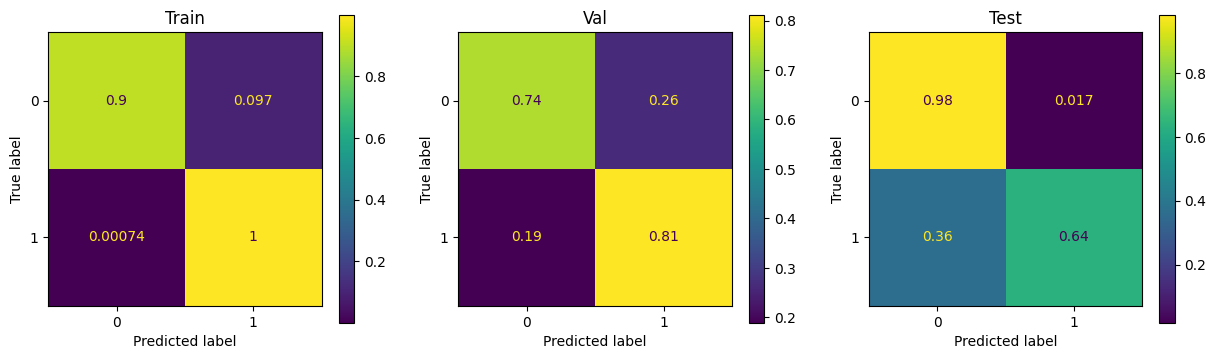

In [14]:
model.load_state_dict(torch.load(os.path.join(out_path,"BestModel/best-model.pt"))['model' ])
fig,(ax1,ax2,ax3) = plt.subplots(1,3)
fig.set_size_inches(15, 4)

def show_results(model,dataloader,device,criterion=torch.nn.CrossEntropyLoss(),ax=None):
    logits,labels = predict_all(model,dataloader,device)
    acc = (logits.argmax(axis=1) == labels).mean()
    loss = criterion(torch.from_numpy(logits),torch.from_numpy(labels)).item()
    f1 = f1_score(labels,logits.argmax(axis=1),average='macro')
    print("F1: {:.2f}% | Acc: {:.2f}% | Loss: {}".format(f1*100,acc*100,loss))
    cm = confusion_matrix(labels,logits.argmax(axis=1),normalize='true')
    ConfusionMatrixDisplay(cm).plot(ax=ax)

print("Train: "),show_results(model,train_loader,device,ax=ax1)
print("Val: "),show_results(model,val_loader,device,ax=ax2)
print("Test: "),show_results(model,test_loader,device,ax=ax3)
ax1.set_title("Train")
ax2.set_title("Val")
ax3.set_title("Test")

plt.show()

In [26]:
state_dict = torch.load(os.path.join(out_path,"BestModel/best-model.pt"))
mu_sigma = np.load(os.path.join(out_path,"mean_std.npz"))
state_dict['mu'] = mu
state_dict['sigma'] = sigma
state_dict['config'] = model_config
state_dict['classes'] = label_map
state_dict['filenames'] = cf_events[cf_events['FILENO'].isin(train_files)]['FILENAME'].drop_duplicates().values
torch.save(state_dict,os.path.join(out_path,f"{out_path}.pt"))

/tmp/ipykernel_13063/2808391836.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(out_path,"BestModel/best-model.pt"))


## Analysis

In [27]:
from neurorobotics_dl.utils import load_checkpoint

model_path = os.path.join(out_path,f'{out_path}.pt')
# model_path = '/home/whiteam/Desktop/exo_training/c8_exo/c8_exo.pt'
# state_dict = torch.load(model_path)

load_checkpoint(model_path)
model = get_class(state_dict['config']['classname'])(**state_dict['config']['options'])
model.load_state_dict(state_dict['model'])
mu,sigma = state_dict['mu'],state_dict['sigma']

/home/whi/tommaso_ws/neurorobotics-dl/neurorobotics_dl/utils.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = load(model_ckpt)


In [28]:
all_logits = []
all_labels = []
dfs = []
device = 'cuda'
eval_batch_size = 512

window_size = 512
window_shift = 16

t_events = cf_events[cf_events['FILENO'].isin([3])]
t_events = cf_events

for fileno in t_events['FILENO'].unique():
    print(fileno)
    ev = t_events[t_events['FILENO']==fileno]

    test_w,test_l = create_windows(eeg, ev, window_size, window_shift)
    test_w = (test_w - mu) / sigma
    test_loader = DataLoader(MyDataset(test_w,test_l), batch_size=eval_batch_size, shuffle=False)
    logits,labels = predict_all(model,test_loader,device)

    df = pd.DataFrame({'logits':logits.tolist(),
                       'preds':logits.argmax(axis=1).tolist(),
                       'labels':labels.tolist()})
    df['FILENO'] = fileno
    # df['MODE'] = ev['MODE'].iloc[0]
    dfs.append(df)

results = pd.concat(dfs)

0


100%|██████████| 5/5 [00:00<00:00, 16.02it/s]


1


100%|██████████| 5/5 [00:00<00:00, 16.75it/s]


2


100%|██████████| 5/5 [00:00<00:00, 16.15it/s]


3


100%|██████████| 5/5 [00:00<00:00, 16.50it/s]


4


100%|██████████| 5/5 [00:00<00:00, 16.50it/s]


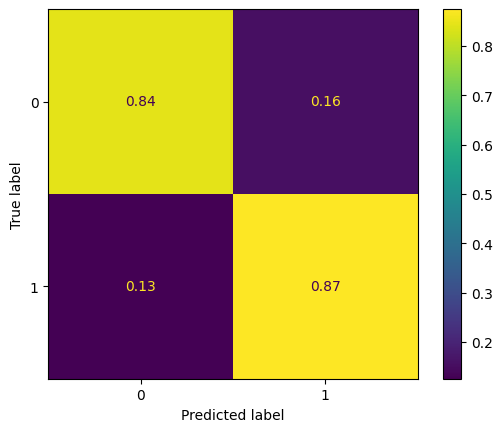

In [29]:
ConfusionMatrixDisplay(confusion_matrix(results['labels'],results['preds'],normalize='true')).plot()

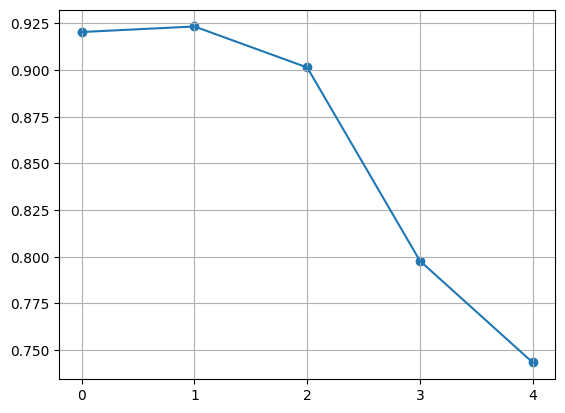

In [30]:
results['correct'] = results['labels'] == results['preds']
acc = results.groupby('FILENO')['correct'].mean().values

# modes = results.groupby('FILENO')['MODE'].first().values
modes =  0
files = results.groupby('FILENO')['FILENO'].first().values
plt.plot(files,acc)
plt.scatter(files[modes==0],acc[modes==0])
plt.scatter(files[modes==1],acc[modes==1])
plt.xticks(files,files)
plt.grid()
plt.show()

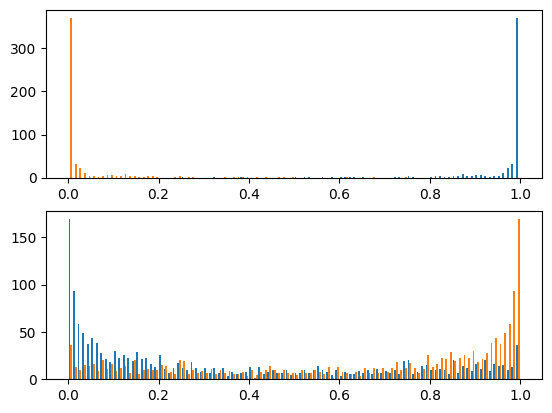

In [31]:
from sklearn.preprocessing import minmax_scale

results = results[results.FILENO==4]
all_logits = np.stack(results['logits'].values)[:,:2]
# all_logits = minmax_scale(all_logits)
all_logits = torch.softmax(torch.from_numpy(all_logits),1).numpy()
# all_logits = (all_logits-(np.min(all_logits,axis=0)))/(np.max(all_logits,axis=0)-np.max(all_logits,axis=0))
labels = results['labels']
plt.subplot(211)

plt.hist(all_logits[labels==0],bins=100)
plt.subplot(212)
plt.hist(all_logits[labels==1],bins=100)
plt.show()